# Regulome Explorer Notebook 2.X


In [1]:
from google.cloud import bigquery

#### Import Python libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind

#### Python convenience functions

We define two convenience functions here:

- **`runQuery`**: a relatively generic BigQuery query-execution wrapper function which can be used to run a query in "dry-run"  mode or not:  the call to the `query()` function itself is inside a `try/except` block and if it fails we return `None`;  otherwise a "dry" will return an empty dataframe, and a "live" run will return the query results as a dataframe

- **`checkQueryResults`**: a generic function that makes sure that what was returned is a dataframe, and checks how many rows are in the returned dataframe

In [3]:
def runQuery ( client, qString, ParameterList,  dryRun=False ):
  
  print ( "\n in runQuery ... " )
  if ( dryRun ):
    print ( "    dry-run only " )
    
  ## set up QueryJobConfig object
  job_config = bigquery.QueryJobConfig()
    
  query_params = [
        bigquery.ArrayQueryParameter('GENENAMES', 'STRING', ParameterList )                             
  ]
  job_config.query_parameters = query_params  
    
  job_config.dry_run = dryRun
  job_config.use_query_cache = True
  job_config.use_legacy_sql = False
  
  ## run the query
  try:
    query_job = client.query ( qString, job_config=job_config )
    ## print ( "    query job state: ", query_job.state )
  except:
    print ( "  FATAL ERROR: query execution failed " )
    return ( None )
  
  ## return results as a dataframe (or an empty dataframe for a dry-run) 
  if ( not dryRun ):
    try:
      df = query_job.to_dataframe()
      if ( query_job.total_bytes_processed==0 ):
        print ( "    the results for this query were previously cached " )
      else:
        print ( "    this query processed {} bytes ".format(query_job.total_bytes_processed) )
      if ( len(df) < 1 ):
        print ( "  WARNING: this query returned NO results ")
      return ( df )
    except:
      print ( "  FATAL ERROR: query execution failed " )
      return ( None )
    
  else:
    print ( "    if not cached, this query will process {} bytes ".format(query_job.total_bytes_processed) )
    ## return an empty dataframe
    return ( pd.DataFrame() )

### SQL Building Functions
- **`build_cohort`**: create a table of SampleBarcodes from user defined Study 

- **`group1_cohort`**: create a set of samples with mutations in a user defined Gene 

In [4]:
def build_cohort ( study ):
  qString = """
      WITH
        --
        -- samples with at least one mutation and gene expression in __study__
        --
        cohort AS (
        SELECT
          Tumor_SampleBarcode as sample_barcode
        FROM
          `pancancer-atlas.Filtered.MC3_MAF_V5_one_per_tumor_sample` 
        WHERE
          ( study = '__study__' )
        GROUP BY
        1
        ),
        sampleGroup AS (
        SELECT
            SampleBarcode as sample_barcode
        FROM
            `pancancer-atlas.Filtered.EBpp_AdjustPANCAN_IlluminaHiSeq_RNASeqV2_genExp_filtered`
        WHERE
            study = '__study__'
            AND SampleBarcode IN
                (select sample_barcode from cohort)
        GROUP BY
          1 
        )
          """.replace('__study__',study)
  return(qString)

In [5]:
def group1_cohort( GeneName ):
  qString = """
    --
    -- The first group has mutations in __Symbol__
    --
    grp1 AS (
    SELECT
        Tumor_SampleBarcode AS sample_barcode
    FROM
        `pancancer-atlas.Filtered.MC3_MAF_V5_one_per_tumor_sample`
    WHERE
        Hugo_Symbol = '__Symbol__'
        AND Tumor_SampleBarcode IN (
            SELECT
                sample_barcode
            FROM
                sampleGroup )
    GROUP BY sample_barcode
    )
    """.replace('__Symbol__',GeneName)
  return(qString)

##  Start the analysis

In [6]:
# Start by getting authorized.
bqclient = bigquery.Client()

###  Select variables to analyze

In [7]:
study = 'UCEC'           # Select Tumor type 
gene_mutation = 'PARP1'  # Name of gene with potential mutation 
gene_expresion = 'IGF2'  # Name of gene for differential gene expression analysis

### Obtain data from biquery
We first will retrieve the gene expression data of a user defined gene (gene_expresion) for each sample in the cohort 

In [8]:
# Build the sql code
sql = (
    build_cohort( study ) + '\n' +
    """
    SELECT 
        SampleBarcode as sample_barcode,
        LOG10( normalized_count + 1 ) as genexp
    FROM 
        `pancancer-atlas.Filtered.EBpp_AdjustPANCAN_IlluminaHiSeq_RNASeqV2_genExp_filtered`
    WHERE
        Symbol = '__Symbol__' 
        AND SampleBarcode IN (SELECT sample_barcode FROM sampleGroup )
    """.replace('__Symbol__', gene_expresion )
)
# bigquery 
res0 = runQuery ( bqclient, sql, [], dryRun=False )


 in runQuery ... 
    the results for this query were previously cached 


We then select the sample codes with mutation in the used defined gene (gene_mutation)

In [9]:
# Build the sql code
sql = (
    build_cohort( study ) + ',\n' +
    group1_cohort( gene_mutation ) + '\n' +
    """
    SELECT * FROM grp1 
    """
)
res1 = runQuery ( bqclient, sql, [], dryRun=False )


 in runQuery ... 
    the results for this query were previously cached 


###  Analyze the results
We then merge the two dataframes (res0 and res1 ) created from bigquey data. 
res1 contain a list of samples with mutation in gene_mutation. We will create a new column (named 'Mutation') on res1 to mark these samples by the letter 'T' which indicate that the sample contains a mutation in gene_mutation.
After merging the tables, the samples with no mutation will be labeled by 'F' in the colum 'Mutation'.

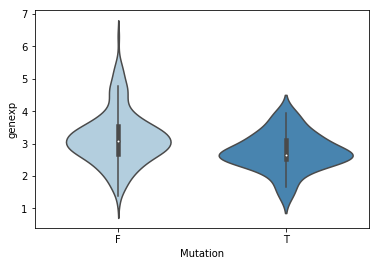

In [11]:
# Merge the two query results  
res1['Mutation'] = 'T'
mydf = pd.merge(res0,res1,on="sample_barcode", how='outer')
# samples with no mutation will be labeled F
mydf.fillna('F',inplace=True)

# violin plot of gene expression cobsidering the two groups (mutated and no mutated) in 'Mutation' column 
sns.violinplot( x=mydf["Mutation"], y=mydf["genexp"], palette="Blues")

We can compute the average of gene expression for the two groups.

In [12]:
mydf.groupby('Mutation').mean()

,genexp
Mutation,
F,3.172452
T,2.747706


Finally, we can also perform a t-test to determine if the difference between the mean of the two groups is statistically significant

In [13]:
Set1 = mydf[mydf['Mutation']=='F']
Set2 = mydf[mydf['Mutation']=='T']
ttest_ind(Set1['genexp'], Set2['genexp'], equal_var=False )

Ttest_indResult(statistic=3.892136471894355, pvalue=0.0003816227439487523)